In [1]:
import torch
import datetime
import math
import matplotlib.pyplot as plt
from torch import optim
from torch import Tensor
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue 
import warnings
warnings.filterwarnings('ignore')     
size=1000;
train_input, train_target, train_classes, test_input, test_target, test_classes = \
    dlc_practical_prologue.generate_pair_sets(size)
train_input, train_target, train_classes = Variable(train_input), Variable(train_target), Variable((train_classes))
test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)

In [2]:
test_input_10 = torch.Tensor(10, 2*1000, 14*14)
test_target_10 = torch.Tensor(10, 1000)
test_classes_10 = torch.Tensor(10, 2*1000)
for i in range(1,10):
    train_input, train_target, train_classes, test_input, test_target, test_classes = \
    dlc_practical_prologue.generate_pair_sets(size)
    test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)
    test_input_10[i,:,:] = test_input.reshape([2000,196])
    test_target_10[i,:] = test_target
    test_classes_10[i,:] = test_classes.reshape([2000])
my_train_input = train_input.reshape([2000,196])
my_train_classes = train_classes.reshape([2000])

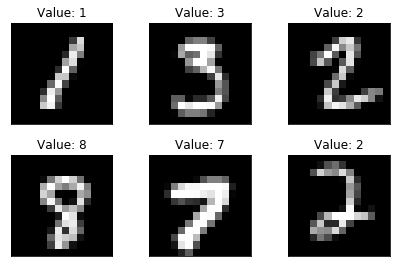

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][0], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(test_classes[i][0]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

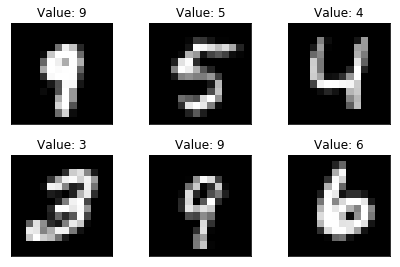

In [4]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][1], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(test_classes[i][1]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

# First neural net
Train the model on all the 2000 images in train_input

In [34]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# number of epoch
num_epochs = 25
# batch size to compute mini-batch
batch_size = 100
# number of pixels in the image 
input_size = 196
# number of possible digit: 0 to 9 
num_class = 10
# small step to find a minima
learning_rate = 0.004
# hidden size
hidden_size = 500
# p dropout
p_dropout = 0

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_class, p_dropout, kernel_size1, kernel_size2, conv_size_out1, conv_size_out2):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, conv_size_out1, kernel_size=kernel_size1, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))
        self.layer2 = nn.Sequential(
            nn.Conv2d(conv_size_out1, conv_size_out2, kernel_size=kernel_size2, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))
        self.fc1 = nn.Linear(conv_size_out2, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_class)
        self.dropout = nn.Dropout(p_dropout)
    
    def forward(self, x, batch_size_images):
        x = x.reshape(batch_size_images,1,14,14)
        out = self.layer1(x)        
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [35]:
def train_model(model_, my_train_input_, my_train_classes_, criterion_, optimizer_,num_epochs_,batch_size_,learning_rate_decay):
    start_time = datetime.datetime.now()
    train_error = []
    test_error = []
    # train function
    if learning_rate_decay:
        lambda_ = lambda epoch: 0.8 ** epoch
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer_, lr_lambda=lambda_)
    for epoch in range(1, num_epochs_+1):
        for i in range(int(len(my_train_input_)/batch_size_)):  
            # Move tensors to the configured device
            images = my_train_input_.narrow(0,i*batch_size_,batch_size_).to(device)
            labels = my_train_classes_.narrow(0,i*batch_size_,batch_size_).to(device)

            # Forward pass
            outputs = model_(images, batch_size_)
            loss = criterion_(outputs, labels)

            # Backward and optimize
            optimizer_.zero_grad()
            loss.backward()
            optimizer_.step()            

        if learning_rate_decay:
            scheduler.step()
        train_error.append(test_accuracy(model_, my_train_input_, my_train_classes_))
        test_ = []
        for i in range(1,10):
            test_.append(test_accuracy(model_, test_input_10[i,:,:], test_classes_10[i,:]))
        test_error.append(sum(test_) / len(test_))
    end_time = datetime.datetime.now()
    training_time = end_time - start_time
    print ('Loss: {:.4f} on epoch: {}, train error: {:.5f}, avg test error on 10 different samples: {:.5f}'.format(loss.item(),epoch,train_error[-1],test_error[-1]))
    return train_error, test_error, training_time

In [36]:
def test_accuracy(model_, my_test_input_, my_test_classes_):
    total = my_test_input_.size(0)

    outputs = model_(my_test_input_, total)
    _, predictions = torch.max(outputs.data, 1)

    well_predicted_count = (predictions.long() == my_test_classes_.long()).sum().item()

    return 1 - well_predicted_count / total

# Testing influence of hidden size

In [64]:
batch_size, hidden_size, learning_rate, LRD, p_dropout = 20, 25, 0.004, True, 0
kernel_size1, kernel_size2, conv_size_out1, conv_size_out2 = 5, 5, 16, 32

hidden_sizes = [10, 25, 50, 75, 100, 200, 1000]
train_error_HS = [[],[],[],[],[],[],[]]
test_error_HS = [[],[],[],[],[],[],[]]
train_time_HS = [[],[],[],[],[],[],[]]
idx = 0
for HS in hidden_sizes:
    print("Hidden size = " + str(HS))
    # creating neural net and run 2 training with and without learning rate decay
    model = NeuralNet(input_size, HS, num_class, p_dropout, kernel_size1, kernel_size2, conv_size_out1, conv_size_out2).to(device)
    # CrossEntropyLoss and optimizer which minimize loss with learning rate step
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    train_error_HS[idx], test_error_HS[idx], train_time_HS[idx] = train_model(model, my_train_input, my_train_classes, criterion, optimizer,num_epochs,batch_size,LRD)
    idx += 1

Hidden size = 10
Loss: 2.2658 on epoch: 25, train error: 0.88900, avg test error on 10 different samples: 0.88567
Hidden size = 25
Loss: 0.0804 on epoch: 25, train error: 0.02700, avg test error on 10 different samples: 0.08800
Hidden size = 50
Loss: 0.0483 on epoch: 25, train error: 0.01900, avg test error on 10 different samples: 0.08172
Hidden size = 75
Loss: 0.0725 on epoch: 25, train error: 0.01900, avg test error on 10 different samples: 0.07733
Hidden size = 100
Loss: 0.0291 on epoch: 25, train error: 0.00750, avg test error on 10 different samples: 0.06239
Hidden size = 200
Loss: 0.0664 on epoch: 25, train error: 0.00800, avg test error on 10 different samples: 0.07589
Hidden size = 1000
Loss: 1.3875 on epoch: 25, train error: 0.61100, avg test error on 10 different samples: 0.62856


In [65]:
for i in range(len(hidden_sizes)):
    print("Train time for hidden size= {}: {} seconds".format(hidden_sizes[i],train_time_HS[i].seconds))

Train time for hidden size= 10: 95 seconds
Train time for hidden size= 25: 94 seconds
Train time for hidden size= 50: 96 seconds
Train time for hidden size= 75: 93 seconds
Train time for hidden size= 100: 93 seconds
Train time for hidden size= 200: 94 seconds
Train time for hidden size= 1000: 82 seconds


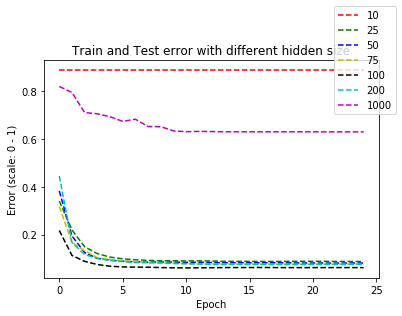

In [67]:
plt.plot(test_error_HS[0],'r--', label='10')
plt.plot(test_error_HS[1], 'g--', label='25')
plt.plot(test_error_HS[2], 'b--', label='50')
plt.plot(test_error_HS[3], 'y--', label='75')
plt.plot(test_error_HS[4], 'k--', label='100')
plt.plot(test_error_HS[5], 'c--', label='200')
plt.plot(test_error_HS[6], 'm--', label='1000')
plt.ylabel('Error (scale: 0 - 1)')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc=7, borderaxespad=0.)
plt.title("Train and Test error with different hidden size")
plt.show()

# Testing influence of convolution size

In [68]:
batch_size, hidden_size, learning_rate, LRD, p_dropout = 20, 100, 0.004, True, 0
kernel_size1, kernel_size2, conv_size_out1, conv_size_out2 = 5, 5, 32, 64

conv_size1 = [4, 8, 16, 32, 64]
conv_size2 = [8, 16, 32, 64, 128]
train_error_CS_1 = [[],[],[],[],[]]
test_error_CS_1 = [[],[],[],[],[]]
train_time_CS_1 = [[],[],[],[],[]]
for i in range(len(conv_size1)):
    print("Conv size 1 = {}, conv size 2 = {}".format(conv_size1[i], conv_size2[i]))
    # creating neural net and run 2 training with and without learning rate decay
    model = NeuralNet(input_size, hidden_size, num_class, p_dropout, kernel_size1, kernel_size2, conv_size1[i], conv_size2[i]).to(device)
    # CrossEntropyLoss and optimizer which minimize loss with learning rate step
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    train_error_CS_1[i], test_error_CS_1[i], train_time_CS_1[i] = train_model(model, my_train_input, my_train_classes, criterion, optimizer,num_epochs,batch_size,LRD)

Conv size 1 = 4, conv size 2 = 8
Loss: 0.2474 on epoch: 25, train error: 0.11050, avg test error on 10 different samples: 0.15694
Conv size 1 = 8, conv size 2 = 16
Loss: 0.1711 on epoch: 25, train error: 0.13300, avg test error on 10 different samples: 0.16778
Conv size 1 = 16, conv size 2 = 32
Loss: 0.0696 on epoch: 25, train error: 0.03200, avg test error on 10 different samples: 0.10178
Conv size 1 = 32, conv size 2 = 64
Loss: 0.0192 on epoch: 25, train error: 0.00200, avg test error on 10 different samples: 0.05428
Conv size 1 = 64, conv size 2 = 128
Loss: 0.0271 on epoch: 25, train error: 0.00050, avg test error on 10 different samples: 0.04578


In [69]:
for i in range(len(conv_size1)):
    print("Train time for conv size 1 = {}, conv size 2 = {}: {} seconds".format(conv_size1[i],conv_size2[i],train_time_CS_1[i].seconds))

Train time for conv size 1 = 4, conv size 2 = 8: 43 seconds
Train time for conv size 1 = 8, conv size 2 = 16: 57 seconds
Train time for conv size 1 = 16, conv size 2 = 32: 101 seconds
Train time for conv size 1 = 32, conv size 2 = 64: 245 seconds
Train time for conv size 1 = 64, conv size 2 = 128: 706 seconds


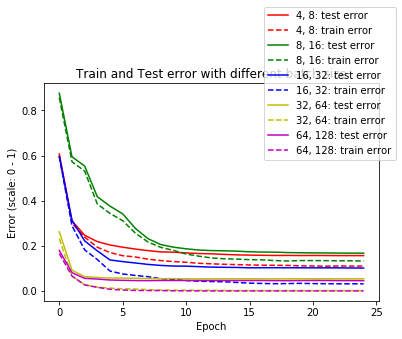

In [70]:
plt.plot(test_error_CS_1[0],'r', label='4, 8: test error')
plt.plot(train_error_CS_1[0],'r--', label='4, 8: train error')
plt.plot(test_error_CS_1[1], 'g', label='8, 16: test error')
plt.plot(train_error_CS_1[1], 'g--', label='8, 16: train error')
plt.plot(test_error_CS_1[2], 'b', label='16, 32: test error')
plt.plot(train_error_CS_1[2], 'b--', label='16, 32: train error')
plt.plot(test_error_CS_1[3], 'y', label='32, 64: test error')
plt.plot(train_error_CS_1[3], 'y--', label='32, 64: train error')
plt.plot(test_error_CS_1[4], 'm', label='64, 128: test error')
plt.plot(train_error_CS_1[4], 'm--', label='64, 128: train error')
plt.ylabel('Error (scale: 0 - 1)')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc=5, borderaxespad=0.)
plt.title("Train and Test error with different batch size")
plt.show()

# Testing influence of kernel size

In [60]:
batch_size, hidden_size, learning_rate, LRD, p_dropout = 20, 25, 0.004, True, 0
kernel_size1, kernel_size2, conv_size_out1, conv_size_out2 = 5, 5, 16, 32

kernel_size = [2, 3, 4, 5]
train_error_KS = [[],[],[],[]]
test_error_KS = [[],[],[],[]]
train_time_KS = [[],[],[],[]]
idx = 0
for i in range(len(conv_size1)):
    print("Kernel size = {}".format(kernel_size[i]))
    # creating neural net and run 2 training with and without learning rate decay
    model = NeuralNet(input_size, hidden_size, num_class, p_dropout, kernel_size[i], kernel_size[i], 32, 64).to(device)
    # CrossEntropyLoss and optimizer which minimize loss with learning rate step
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    train_error_KS[idx], test_error_KS[idx], train_time_KS[idx] = train_model(model, my_train_input, my_train_classes, criterion, optimizer,num_epochs,BS,LRD)
    idx += 1

Kernel size = 2


RuntimeError: size mismatch, m1: [100 x 256], m2: [64 x 25] at c:\a\w\1\s\windows\pytorch\aten\src\th\generic/THTensorMath.cpp:940

In [ ]:
for i in range(len(conv_size1)):
    print("Train time for kernel size 1 = {}: {} seconds".format(kernel_size[i],train_time_CS[i].seconds))

In [ ]:
plt.plot(test_error_BS[0],'r', label='4, 8: test error')
plt.plot(test_error_BS[1], 'g', label='8, 16: test error')
plt.plot(test_error_BS[2], 'b', label='16, 32: test error')
plt.plot(test_error_BS[3], 'y', label='32, 64: test error')
plt.plot(train_error_BS[0],'r--', label='4, 8: train error')
plt.plot(train_error_BS[1], 'g--', label='8, 16: train error')
plt.plot(train_error_BS[2], 'b--', label='16, 32: train error')
plt.plot(train_error_BS[3], 'y--', label='32, 64: train error')
plt.ylabel('Error (scale: 0 - 1)')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc=5, borderaxespad=0.)
plt.title("Train and Test error with different batch size")
plt.show()

# Testing influence of Batch Size

In [71]:
batch_size, hidden_size, learning_rate, LRD, p_dropout = 20, 100, 0.004, True, 0
kernel_size1, kernel_size2, conv_size_out1, conv_size_out2 = 5, 5, 16, 32

batch_sizes = [2, 5, 20, 50, 100]
train_error_BS = [[],[],[],[],[]]
test_error_BS = [[],[],[],[],[]]
train_time_BS = [[],[],[],[],[]]
idx = 0
for BS in batch_sizes:
    print("Batch size = " + str(BS))
    # creating neural net and run 2 training with and without learning rate decay
    model = NeuralNet(input_size, hidden_size, num_class, p_dropout, kernel_size1, kernel_size2, conv_size_out1, conv_size_out2).to(device)
    # CrossEntropyLoss and optimizer which minimize loss with learning rate step
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    train_error_BS[idx], test_error_BS[idx], train_time_BS[idx] = train_model(model, my_train_input, my_train_classes, criterion, optimizer,num_epochs,BS,LRD)
    idx += 1

Batch size = 2
Loss: 0.0000 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.04839
Batch size = 5
Loss: 0.7335 on epoch: 25, train error: 0.22850, avg test error on 10 different samples: 0.28611
Batch size = 20
Loss: 0.2541 on epoch: 25, train error: 0.03200, avg test error on 10 different samples: 0.08967
Batch size = 50
Loss: 0.2295 on epoch: 25, train error: 0.06050, avg test error on 10 different samples: 0.09606
Batch size = 100
Loss: 0.4965 on epoch: 25, train error: 0.16300, avg test error on 10 different samples: 0.19533


In [72]:
for i in range(len(batch_sizes)):
    print("Train time for batch size= {}: {} seconds".format(batch_sizes[i],train_time_BS[i].seconds))

Train time for batch size= 2: 160 seconds
Train time for batch size= 5: 132 seconds
Train time for batch size= 20: 99 seconds
Train time for batch size= 50: 96 seconds
Train time for batch size= 100: 76 seconds


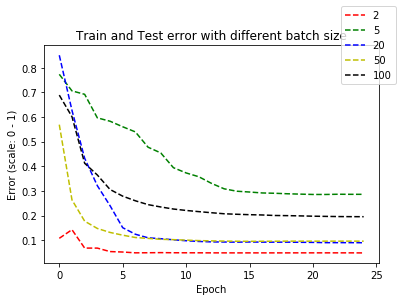

In [73]:
plt.plot(test_error_BS[0],'r--', label='2')
plt.plot(test_error_BS[1], 'g--', label='5')
plt.plot(test_error_BS[2], 'b--', label='20')
plt.plot(test_error_BS[3], 'y--', label='50')
plt.plot(test_error_BS[4], 'k--', label='100')
plt.ylabel('Error (scale: 0 - 1)')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc=5, borderaxespad=0.)
plt.title("Train and Test error with different batch size")
plt.show()

# Testing the influence of learning rate decay

In [82]:
batch_size, hidden_size, learning_rate, LRD, p_dropout = 2, 50, 0.004, True, 0
kernel_size1, kernel_size2, conv_size_out1, conv_size_out2 = 5, 5, 64, 128

learning_rate_decay = [False, True]
train_error_LRD = [[],[]]
test_error_LRD = [[],[]]
time_to_train_LRD = [[],[]]
idx = 0
for LRD in learning_rate_decay:    
    print("learning rate = " + str(LRD))
    # creating neural net and run 2 training with and without learning rate decay
    model = NeuralNet(input_size, hidden_size, num_class, p_dropout, kernel_size1, kernel_size2, conv_size_out1, conv_size_out2).to(device)
    # CrossEntropyLoss and optimizer which minimize loss with learning rate step
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate+0.001)  
    train_error_LRD[idx], test_error_LRD[idx], time_to_train_LRD[idx] = train_model(model, my_train_input, my_train_classes, criterion, optimizer,num_epochs,batch_size,LRD)
    idx += 1

learning rate = False
Loss: 0.0000 on epoch: 25, train error: 0.00700, avg test error on 10 different samples: 0.05561
learning rate = True
Loss: 0.0000 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.04661


In [85]:
for i in range(len(time_to_train_LRD)):
    print("Train time with learning rate decay = {}: {} seconds".format(learning_rate_decay[i],time_to_train_LRD[i].seconds))

Train time with learning rate decay = False: 840 seconds
Train time with learning rate decay = True: 772 seconds


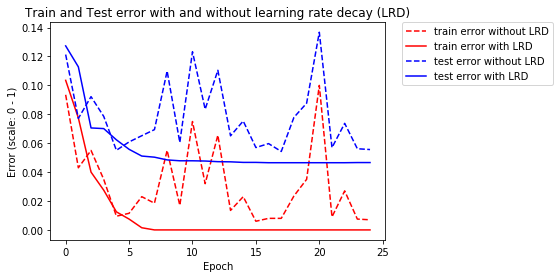

In [86]:
plt.plot(train_error_LRD[0], 'r--', label='train error without LRD')
plt.plot(train_error_LRD[1], 'r', label='train error with LRD')
plt.plot(test_error_LRD[0], 'b--', label='test error without LRD')
plt.plot(test_error_LRD[1], 'b', label='test error with LRD')
plt.ylabel('Error (scale: 0 - 1)')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Train and Test error with and without learning rate decay (LRD)")
plt.show()

# Testing different learning rate values

In [106]:
batch_size, hidden_size, learning_rate, LRD, p_dropout = 2, 50, 0.004, True, 0
kernel_size1, kernel_size2, conv_size_out1, conv_size_out2 = 5, 5, 64, 128

learning_rates = [0.0005, 0.001, 0.002, 0.004, 0.007, 0.01]
train_error_LR = [[],[],[],[],[],[]]
test_error_LR = [[],[],[],[],[],[]]
time_to_train_LR = [[],[],[],[],[],[]]
idx = 0
for LR in learning_rates:    
    print("learning rate = " + str(LR))
    # creating neural net and run 2 training with and without learning rate decay
    model = NeuralNet(input_size, hidden_size, num_class, p_dropout, kernel_size1, kernel_size2, conv_size_out1, conv_size_out2).to(device)
    # CrossEntropyLoss and optimizer which minimize loss with learning rate step
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)  
    train_error_LR[idx], test_error_LR[idx], time_to_train_LR[idx] = train_model(model, my_train_input, my_train_classes, criterion, optimizer,num_epochs,batch_size,LRD)
    idx += 1

learning rate = 0.0005
Loss: 0.0002 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.04444
learning rate = 0.001
Loss: 0.0003 on epoch: 25, train error: 0.00600, avg test error on 10 different samples: 0.05233
learning rate = 0.002
Loss: 0.0000 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.04861
learning rate = 0.004
Loss: 0.0000 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.03733
learning rate = 0.007
Loss: 2.1936 on epoch: 25, train error: 0.88900, avg test error on 10 different samples: 0.88567
learning rate = 0.01
Loss: nan on epoch: 25, train error: 0.89800, avg test error on 10 different samples: 0.90094


In [107]:
for i in range(len(learning_rates)):
    print("Train time with learning rate = {}: {} seconds".format(learning_rates[i],time_to_train_LR[i].seconds))

Train time with learning rate = 0.0005: 719 seconds
Train time with learning rate = 0.001: 724 seconds
Train time with learning rate = 0.002: 716 seconds
Train time with learning rate = 0.004: 701 seconds
Train time with learning rate = 0.007: 684 seconds
Train time with learning rate = 0.01: 713 seconds


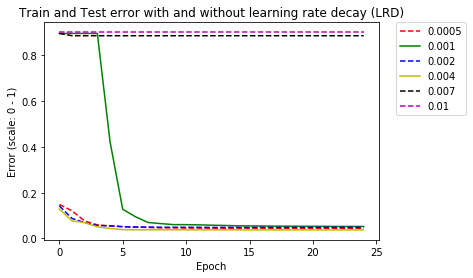

In [108]:
plt.plot(test_error_LR[0], 'r--', label='0.0005')
plt.plot(test_error_LR[1], 'g', label='0.001')
plt.plot(test_error_LR[2], 'b--', label='0.002')
plt.plot(test_error_LR[3], 'y', label='0.004')
plt.plot(test_error_LR[4], 'k--', label='0.007')
plt.plot(test_error_LR[5], 'm--', label='0.01')
plt.ylabel('Error (scale: 0 - 1)')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Train and Test error with and without learning rate decay (LRD)")
plt.show()

# Testing regularization technique: Dropout

In [87]:
batch_size, hidden_size, learning_rate, LRD, p_dropout = 2, 50, 0.004, True, 0
kernel_size1, kernel_size2, conv_size_out1, conv_size_out2 = 5, 5, 64, 128

dropouts = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
idx = 0
train_error_dropout = [[],[],[],[],[],[],[],[]]
test_error_dropout = [[],[],[],[],[],[],[],[]]
train_time_dropout = [[],[],[],[],[],[],[],[]]
for dropout_ in dropouts:
    print("Dropout= " + str(dropout_))
    # creating neural net and run 2 training with and without learning rate decay
    model = NeuralNet(input_size, hidden_size, num_class, dropout_, kernel_size1, kernel_size2, conv_size_out1, conv_size_out2).to(device)
    # CrossEntropyLoss and optimizer which minimize loss with learning rate step
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    train_error_dropout[idx], test_error_dropout[idx], train_time_dropout[idx] = train_model(model, my_train_input, my_train_classes, criterion, optimizer,num_epochs,batch_size,LRD)
    idx += 1

Dropout= 0
Loss: 0.0000 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.03500
Dropout= 0.1
Loss: 0.0000 on epoch: 25, train error: 0.00300, avg test error on 10 different samples: 0.04044
Dropout= 0.2
Loss: 0.0000 on epoch: 25, train error: 0.00450, avg test error on 10 different samples: 0.05206
Dropout= 0.3
Loss: 0.0000 on epoch: 25, train error: 0.00750, avg test error on 10 different samples: 0.04989
Dropout= 0.4
Loss: 0.0000 on epoch: 25, train error: 0.04150, avg test error on 10 different samples: 0.10006
Dropout= 0.5
Loss: 0.0008 on epoch: 25, train error: 0.02500, avg test error on 10 different samples: 0.06906
Dropout= 0.6
Loss: 2.1951 on epoch: 25, train error: 0.88900, avg test error on 10 different samples: 0.88567
Dropout= 0.7
Loss: 0.1304 on epoch: 25, train error: 0.26800, avg test error on 10 different samples: 0.30828


In [88]:
for i in range(len(dropouts)):
    print("Train time for dropout= {}: {} minutes".format(dropouts[i],train_time_dropout[i].seconds//60))

Train time for dropout= 0: 12 minutes
Train time for dropout= 0.1: 11 minutes
Train time for dropout= 0.2: 12 minutes
Train time for dropout= 0.3: 12 minutes
Train time for dropout= 0.4: 13 minutes
Train time for dropout= 0.5: 13 minutes
Train time for dropout= 0.6: 13 minutes
Train time for dropout= 0.7: 13 minutes


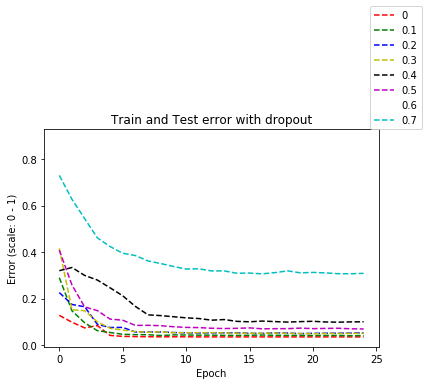

In [89]:
plt.plot(test_error_dropout[0],'r--', label='0')
plt.plot(test_error_dropout[1], 'g--', label='0.1')
plt.plot(test_error_dropout[2], 'b--', label='0.2')
plt.plot(test_error_dropout[3], 'y--', label='0.3')
plt.plot(test_error_dropout[4], 'k--', label='0.4')
plt.plot(test_error_dropout[5], 'm--', label='0.5')
plt.plot(test_error_dropout[6], 'w--', label='0.6')
plt.plot(test_error_dropout[7], 'c--', label='0.7')
plt.ylabel('Error (scale: 0 - 1)')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc=8, borderaxespad=0.)
plt.title("Train and Test error with dropout")
plt.show()

# Comparing Neural nets with 2 conv 2 linear, 2 conv 1 linear layers

In [90]:
# Fully connected neural network
class NeuralNet2conv1linear(nn.Module):
    def __init__(self, input_size, hidden_size, num_class, dropout_p):
        super(NeuralNet2conv1linear, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, conv_size_out1, kernel_size=kernel_size1, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))
        self.layer2 = nn.Sequential(
            nn.Conv2d(conv_size_out1, conv_size_out2, kernel_size=kernel_size2, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))
        self.fc1 = nn.Linear(conv_size_out2, num_class)
    
    def forward(self, x, batch_size_images):
        x = x.reshape(batch_size_images,1,14,14)
        out = self.layer1(x)        
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out

In [116]:
batch_size, hidden_size, learning_rate, LRD, p_dropout = 2, 60, 0.004, True, 0
kernel_size1, kernel_size2, conv_size_out1, conv_size_out2 = 5, 5, 64, 128

# creating neural net and run 2 training with and without learning rate decay
model = NeuralNet(input_size, hidden_size, num_class, dropout_, kernel_size1, kernel_size2, conv_size_out1, conv_size_out2).to(device)
# CrossEntropyLoss and optimizer which minimize loss with learning rate step
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2conv2linear.parameters(), lr=learning_rate)  
train_error_2conv2linear, test_error_2conv2linear, train_time_2conv2linear = train_model(model_2conv2linear, my_train_input, my_train_classes, criterion, optimizer,num_epochs,batch_size,LRD)
    

Loss: 0.0000 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.04244


In [92]:
# creating neural net and run 2 training with and without learning rate decay
model_2conv1linear = NeuralNet2conv1linear(input_size, hidden_size, num_class, p_dropout).to(device)
# CrossEntropyLoss and optimizer which minimize loss with learning rate step
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2conv1linear.parameters(), lr=learning_rate)  
train_error_2conv1linear, test_error_2conv1linear, train_time_2conv1linear = train_model(model_2conv1linear, my_train_input, my_train_classes, criterion, optimizer,num_epochs,batch_size,LRD)
    

Loss: 0.0000 on epoch: 25, train error: 0.00000, avg test error on 10 different samples: 0.07183


In [94]:
print("Train time for 3 layers: {} minutes".format(train_time_2conv2linear.seconds//60))
print("Train time for 4 layers: {} minutes".format(train_time_2conv1linear.seconds//60))

Train time for 3 layers: 13 minutes
Train time for 4 layers: 12 minutes


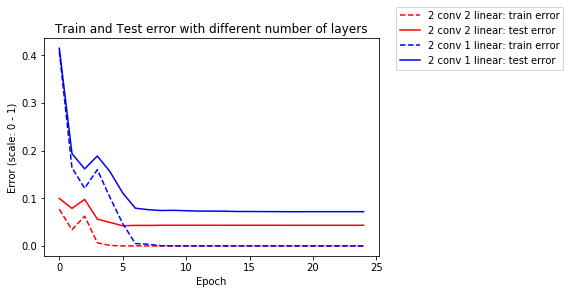

In [95]:
plt.plot(train_error_2conv2linear,'r--', label='2 conv 2 linear: train error')
plt.plot(test_error_2conv2linear, 'r', label='2 conv 2 linear: test error')
plt.plot(train_error_2conv1linear, 'b--', label='2 conv 1 linear: train error')
plt.plot(test_error_2conv1linear,'b', label='2 conv 1 linear: test error')
plt.ylabel('Error (scale: 0 - 1)')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.)
plt.title("Train and Test error with different number of layers")
plt.show()

# Testing on the 2 batches
A model for the two batch of 1000 images

In [96]:
my_test_input1 = test_input[:,0,:]
my_test_input2 = test_input[:,1,:]
my_test_classes1 = test_classes[0:1000,0]
my_test_classes2 = test_classes[0:1000,1]

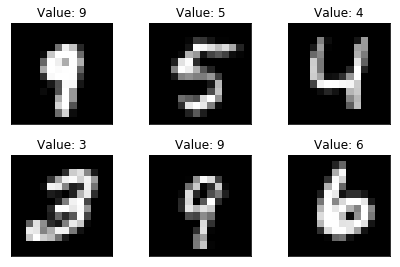

In [97]:
# verifying the digits and labels
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(my_test_input2[i], cmap='gray', interpolation='none')
  plt.title("Value: {}".format(my_test_classes2[i]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

In [98]:
my_test_input1=my_test_input1.reshape(1000,196)
my_test_input2=my_test_input2.reshape(1000,196)

In [99]:
print("Error on batch 1: {}".format(test_accuracy(model_2conv2linear, my_test_input1, my_test_classes1)))
print("Error on batch 2: {}".format(test_accuracy(model_2conv2linear, my_test_input2, my_test_classes2)))

Error on batch 1: 0.039000000000000035
Error on batch 2: 0.04400000000000004


# Building neural net for Digit Comparison

In [100]:
# number of epoch
num_epochs_dc = 21
# batch size to compute mini-batch
batch_size_dc = 10
# number of pixels in the image 
input_size_dc = 2
# number of possible digit: 0 to 9 
num_class_dc = 1
# small step to find a minima
learning_rate_dc = 0.004
# hidden size
hidden_size_dc = 200

# Fully connected neural network with one hidden layer
class NeuralNet_dc(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(NeuralNet_dc, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)  
        self.layer3 = nn.Linear(hidden_size, num_class)  
    
    def forward(self, x, batch_size_):
        outputs = self.layer1(x)
        outputs = self.relu(outputs)
        outputs = self.layer2(outputs)
        outputs = self.relu(outputs)
        outputs = self.layer3(outputs)
        return outputs.reshape([1, batch_size_])[0]
        
    
# creating neural net
model_dc = NeuralNet_dc(input_size_dc, hidden_size_dc, num_class_dc).to(device)

# MSELoss and optimizer which minimize loss with learning rate step
criterion_dc = nn.MSELoss()
optimizer_dc = torch.optim.SGD(model_dc.parameters(), lr=learning_rate_dc)  

# train function
for epoch in range(num_epochs_dc):
    for i in range(int(len(train_classes)/batch_size_dc)):  
        # Move tensors to the configured device
        inputs = train_classes.narrow(0,i*batch_size_dc,batch_size_dc).to(device).float()
        labels = train_target.narrow(0,i*batch_size_dc,batch_size_dc).to(device)

        # Forward pass
        outputs = model_dc(inputs,batch_size_dc)
        loss = criterion_dc(outputs, labels.float())
        
        # Backward and optimize
        optimizer_dc.zero_grad()
        loss.backward()
        optimizer_dc.step()
    if(epoch % 5 == 0):    
        print ('Loss: {:.4f} on epoch: {}'.format(loss.item(),epoch+1))

Loss: 0.1186 on epoch: 1
Loss: 0.0293 on epoch: 6
Loss: 0.0146 on epoch: 11
Loss: 0.0092 on epoch: 16
Loss: 0.0066 on epoch: 21


In [101]:
# test function
def test_accuracy_dc(model_, my_test_input_, my_test_classes_):

    total = my_test_input_.size(0)

    outputs = model_(my_test_input_.float(),total)
    t = Variable(torch.Tensor([0.5]))
    predictions = (outputs > t).float() * 1

    well_predicted_count = (predictions == my_test_classes_.float()).sum().item()
    print('Accuracy: {} %'.format(100 * well_predicted_count / total))

test_accuracy_dc(model_dc, test_classes, test_target)


Accuracy: 100.0 %


# Running both neural networks in sequence

In [117]:
# test function
def getting_y(model_, my_test_input_, my_test_classes_):
    total = my_test_input_.size(0)
    outputs = model_(my_test_input_,total)
    _, predictions = torch.max(outputs.data, 1)
    well_predicted_count = (predictions == my_test_classes_).sum().item()

    print('Accuracy: {} %'.format(100 * well_predicted_count / total))
    return predictions

y1 = getting_y(model_2conv2linear, my_test_input1, my_test_classes1)
y2 = getting_y(model_2conv2linear, my_test_input2, my_test_classes2)
y_test_classes = torch.tensor([y1.tolist(), y2.tolist()]).transpose_(0, 1)
y_test_classes

Accuracy: 96.2 %
Accuracy: 95.7 %


tensor([[1, 9],
        [3, 5],
        [2, 4],
        ...,
        [4, 4],
        [3, 5],
        [2, 0]])

In [118]:
# test function
def digit_comparison(model_, my_test_input_, my_test_classes_):
    total = my_test_input_.size(0)

    outputs = model_(my_test_input_.float())
    t = Variable(torch.Tensor([0.5]))
    predictions = (outputs > t).float() * 1

    well_predicted_count = (predictions == my_test_classes_.float()).sum().item()
    print('Accuracy: {} %'.format(100 * well_predicted_count / total))

test_accuracy_dc(model_dc, y_test_classes, test_target)

Accuracy: 97.4 %
